In [7]:
# === Cell 4: Verify fine-tuning result ===
from tensorflow.keras.models import load_model

model_path = "../notebook/safe_glyphnet_best_v2.keras"
print("Checking if model exists:", model_path)
if not os.path.exists(model_path):
    print("❌ Model file not found – check your training logs above.")
else:
    m = load_model(model_path)
    print("✅ Model loaded successfully.")
    print("Input shape :", m.input_shape)
    print("Output shape:", m.output_shape)


Checking if model exists: ../notebook/safe_glyphnet_best_v2.keras
✅ Model loaded successfully.
Input shape : (None, 96, 96, 1)
Output shape: (None, 3)


In [5]:
# === Cell 3 (paste this exactly) ===
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import os

# config (will use values from previous cells if present)
MODEL_OUT = globals().get("MODEL_OUT", "../notebook/safe_glyphnet_best_v2.keras")  # relative to notebook/
EPOCHS = globals().get("EPOCHS", 8)
LR = globals().get("LR", 1e-4)
BATCH = globals().get("BATCH", 64)

print("Train params -> epochs:", EPOCHS, "batch:", BATCH, "lr:", LR)
print("Saving best model to:", MODEL_OUT)

# safety: check train_flow and val_flow exist
try:
    train_flow
    val_flow
except NameError:
    raise RuntimeError("train_flow / val_flow not found. Make sure you ran Cell 2 successfully.")

# sanity: ensure model output units matches number of classes
out_units = base.output_shape[-1] if base.output_shape else None
print("Model output units:", out_units, "Detected classes:", NUM_CLASSES)
if out_units and out_units != NUM_CLASSES:
    print("WARNING: model output units != number of classes detected. This will cause wrong labels. Proceed only if you know the mapping is correct.")

# prepare callbacks
ckpt = ModelCheckpoint(MODEL_OUT, monitor="val_loss", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
early = EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

# compile
base.compile(optimizer=Adam(LR), loss='categorical_crossentropy', metrics=['accuracy'])

# train
history = base.fit(
    train_flow,
    validation_data=val_flow,
    epochs=EPOCHS,
    callbacks=[ckpt, reduce_lr, early]
)

# save final model (checkpoint already saved best)
final_path = MODEL_OUT if os.path.exists(MODEL_OUT) else MODEL_OUT.replace(".keras", "_final.keras")
base.save(final_path)
print("Finished training. Best model saved at:", MODEL_OUT)
# === end Cell 3 ===


Train params -> epochs: 8 batch: 64 lr: 0.0001
Saving best model to: notebook/safe_glyphnet_best_v2.keras
Model output units: 3 Detected classes: 3
Epoch 1/8
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5058 - loss: 1.5084
Epoch 1: val_loss improved from None to 0.73243, saving model to notebook/safe_glyphnet_best_v2.keras
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 440s 210ms/step - accuracy: 0.6062 - loss: 0.9572 - val_accuracy: 0.6655 - val_loss: 0.7324 - learning_rate: 1.0000e-04
Epoch 2/8
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.7226 - loss: 0.6566
Epoch 2: val_loss improved from 0.73243 to 0.67606, saving model to notebook/safe_glyphnet_best_v2.keras
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 439s 211ms/step - accuracy: 0.7335 - loss: 0.6345 - val_accuracy: 0.7009 - val_loss: 0.6761 - learning_rate: 1.0000e-04
Epoch 3/8
2086/2086 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7622 - loss: 0.5757
Epoch 3: val_loss did not improve from 0.67606
2086/2086 ━━━━━━━━━━━━━━━━━━━

In [4]:
# === Cell 2 (paste this exactly) ===
from pathlib import Path
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# If you set MODEL_IN and DATA_DIR in a previous cell, this will keep them.
# Otherwise default to the notebook-local model file and dataset one level up.
try:
    MODEL_IN  # if defined earlier
except NameError:
    MODEL_IN = "safe_glyphnet_best.keras"   # model file expected in this notebook/ folder

# dataset is in project root ../dataset/Train because notebook cwd is project_ai/notebook
DATA_DIR = "../dataset/Train"

print("Using MODEL_IN =", MODEL_IN)
print("Using DATA_DIR =", DATA_DIR)
data_path = Path(DATA_DIR)
if not data_path.exists():
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}\nMake sure folder exists and contains class subfolders (Normal, Reversal, Corrected).")

# Load model (throws if model file missing)
print("Loading model from:", MODEL_IN)
base = load_model(MODEL_IN)

# Infer height/width from model.input_shape
input_shape = base.input_shape  # typically (None, H, W, C)
if input_shape and len(input_shape) >= 3 and input_shape[1] and input_shape[2]:
    IMG_H = int(input_shape[1])
    IMG_W = int(input_shape[2])
    print(f"Inferred model input (H x W): {IMG_H} x {IMG_W}")
else:
    IMG_W, IMG_H = (28, 28)
    print("Could not infer model input shape — falling back to 28x28")

# Check for class subfolders
subdirs = [d.name for d in sorted(data_path.iterdir()) if d.is_dir()]
print("Found class subfolders under DATA_DIR:", subdirs)
if not subdirs:
    raise FileNotFoundError(f"No class subfolders found in {DATA_DIR}. Create subfolders like Normal, Reversal, Corrected and add images.")

# Data generators
BATCH = globals().get("BATCH", 64)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.05,
    zoom_range=0.08,
    fill_mode='nearest',
    validation_split=0.12
)

train_flow = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_H, IMG_W),   # (height, width)
    color_mode='grayscale',
    batch_size=BATCH,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_flow = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_H, IMG_W),
    color_mode='grayscale',
    batch_size=BATCH,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Detected classes (name -> index):", train_flow.class_indices)
NUM_CLASSES = len(train_flow.class_indices)
print("Number of classes:", NUM_CLASSES)
# === end Cell 2 ===


Using MODEL_IN = notebook/safe_glyphnet_best.keras
Using DATA_DIR = ../dataset/Train
Loading model from: notebook/safe_glyphnet_best.keras
Inferred model input (H x W): 96 x 96
Found class subfolders under DATA_DIR: ['Corrected', 'Normal', 'Reversal']
Found 133452 images belonging to 3 classes.
Found 18197 images belonging to 3 classes.
Detected classes (name -> index): {'Corrected': 0, 'Normal': 1, 'Reversal': 2}
Number of classes: 3


In [3]:
# quick diagnostics - run this cell
import os
print("Current working directory:", os.getcwd())
print("List top-level files/folders:")
print(sorted(os.listdir(".")))
print("\nIf dataset exists, show its contents (if not, you'll see an error):")
if os.path.exists("dataset"):
    print("dataset/ ->", sorted(os.listdir("dataset")))
else:
    print("dataset/ not found")



Current working directory: /home/madhavan_1502/project_ai/notebook
List top-level files/folders:
['best_glyphnet.keras', 'best_model.h5', 'best_model.keras', 'best_model_finetuned.keras', 'best_model_finetuned_balanced.keras', 'eval_model.ipynb', 'notebook', 'train_clean_glyphs.ipynb', 'train_clean_glyphs.py', 'train_model.ipynb']

If dataset exists, show its contents (if not, you'll see an error):
dataset/ not found


In [1]:
# cell 1: imports & config
from pathlib import Path
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
import os

# CONFIG - adjust if needed
MODEL_IN = "notebook/safe_glyphnet_best.keras"
MODEL_OUT = "notebook/safe_glyphnet_best_v2.keras"
DATA_DIR = "dataset/Train"   # expects subfolders per class e.g. Normal,Reversal,Corrected
BATCH = 64
EPOCHS = 8
LR = 1e-4

print("Config:", MODEL_IN, "->", MODEL_OUT, "| DATA_DIR:", DATA_DIR)



2025-10-28 16:58:13.855871: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 16:58:15.345894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-28 16:58:19.323283: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Config: notebook/safe_glyphnet_best.keras -> notebook/safe_glyphnet_best_v2.keras | DATA_DIR: dataset/Train


In [55]:
# Cell: visual sample of crops with predictions
import matplotlib.pyplot as plt

def show_sample_crops(img, per_char_info, max_show=24):
    crops = []
    infos = per_char_info[:]
    # choose a spread of indices (or random)
    if len(infos) > max_show:
        step = max(1, len(infos)//max_show)
        infos = infos[::step][:max_show]
    fig_cols = 6
    fig_rows = (len(infos)+fig_cols-1)//fig_cols
    plt.figure(figsize=(fig_cols*2, fig_rows*2))
    for i, info in enumerate(infos):
        b = info['box']
        crop = img.crop((b['x1'], b['y1'], b['x2'], b['y2'])).convert("L")
        plt.subplot(fig_rows, fig_cols, i+1)
        plt.imshow(crop, cmap='gray')
        plt.axis('off')
        lab = f"{info['pred_label']} {info['prob']:.2f}"
        if info.get('corrected_char'):
            lab += f" -> {info['corrected_char']}"
        plt.title(lab, fontsize=8)
    plt.tight_layout()
    plt.show()

try:
    show_sample_crops(img, per_char_info, max_show=24)
except NameError:
    print("img or per_char_info missing. Re-run pipeline cell that sets these variables.")


img or per_char_info missing. Re-run pipeline cell that sets these variables.


In [54]:
# Cell: summary of per-char labels & basic stats
from collections import Counter
import numpy as np
def summarize_per_char(per_char_info):
    labels = [c['pred_label'] for c in per_char_info]
    probs = [c['prob'] for c in per_char_info]
    cnt = Counter(labels)
    print("Label counts:", dict(cnt))
    print("Total chars:", len(labels))
    if probs:
        print("Prob (top) stats: mean {:.3f}, median {:.3f}, max {:.3f}".format(np.mean(probs), np.median(probs), np.max(probs)))
    # show a few low-confidence predictions
    sorted_by_prob = sorted(enumerate(per_char_info), key=lambda x: x[1]['prob'])
    print("\nLowest-confidence predictions (index, label, prob):")
    for i, info in sorted_by_prob[:10]:
        print(i, info['pred_label'], round(info['prob'],3), info['orig_char'], "->", info.get('corrected_char'))
    return cnt

# If you have a variable per_char_info from the last run:
try:
    cnt = summarize_per_char(per_char_info)
except NameError:
    print("per_char_info not in memory. Re-run the full test cell (the one that calls reconstruct_and_correct) first.")


per_char_info not in memory. Re-run the full test cell (the one that calls reconstruct_and_correct) first.


In [ ]:
import gradio as gr
from PIL import Image
from IPython.display import display, HTML

def analyze_uploaded_image(pil_img, scale=2, adapt_block=25, adapt_C=10, min_area=40, min_h=8, space_gap_ratio=1.6):
    try:
        # Step 1: Extract handwriting boxes
        boxes, bin_img = get_char_boxes_handwriting(
            pil_img, debug_ocr_per_crop=False,
            scale=scale, adapt_block=adapt_block, adapt_C=adapt_C,
            min_area=min_area, min_h=min_h
        )

        # Step 2: Run your trained model’s reconstruction/correction
        original_text, corrected_text, highlighted_html, per_char_info = reconstruct_and_correct(
            pil_img, boxes, space_gap_ratio=space_gap_ratio, batch_size=128
        )

        # Step 3: Analyze dyslexia
        dys = analyze_dyslexia(per_char_info, reversal_threshold=0.02)

        result_str = f"Dyslexia detected: {'✅ YES' if dys['is_dyslexic'] else '❌ NO'}\n"
        result_str += f"Reversal fraction: {dys['reversal_fraction']:.3f}\n"
        result_str += f"Characters analyzed: {dys['total']} | Reversed: {dys['reversals']} | Corrected: {dys['corrected']}"

        return highlighted_html, result_str

    except Exception as e:
        return f"<p style='color:red'>Error: {e}</p>", "Processing failed."

# Create the Gradio interface
with gr.Blocks() as dyslexia_app:
    gr.Markdown("## 🧠 Dyslexia Detection and Paragraph Correction")
    gr.Markdown("Upload a handwritten paragraph image below to analyze dyslexia and view corrections.")

    img_input = gr.Image(type="pil", label="Upload paragraph image")
    btn = gr.Button("🔍 Analyze Paragraph")
    html_output = gr.HTML(label="Corrected Paragraph with Highlights")
    text_output = gr.Textbox(label="Dyslexia Analysis", lines=3)

    btn.click(
        fn=analyze_uploaded_image,
        inputs=[img_input],
        outputs=[html_output, text_output]
    )

# Launch locally
dyslexia_app.launch(server_name="127.0.0.1", server_port=7864, inbrowser=True)



* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/fastapi/applications.py", line 1134, in __call__
    await super().__call__(scope, receive, send)
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  Fil

In [51]:
# Small Gradio debug UI for the new extractor — runs on 127.0.0.1:7863
import gradio as gr
from PIL import Image, ImageDraw
import webbrowser, threading, time

def debug_new_extractor(pil_img, scale=2, adapt_block=25, adapt_C=10, min_area=40, min_h=8):
    if pil_img is None:
        return "No image", None, ""
    boxes, crop_texts, bin_img = get_char_boxes_handwriting(
        pil_img, debug_ocr_per_crop=True,
        scale=scale, blur_ksize=3, adapt_block=adapt_block, adapt_C=adapt_C,
        min_area=min_area, min_h=min_h
    )
    # draw boxes on original image
    vis = pil_img.convert("RGB").copy()
    draw = ImageDraw.Draw(vis)
    for i,b in enumerate(boxes):
        draw.rectangle([b['x1'], b['y1'], b['x2'], b['y2']], outline=(255,0,0), width=2)
        if crop_texts and i < len(crop_texts):
            txt = crop_texts[i][:2]
            draw.text((b['x1'], max(0, b['y1']-12)), txt, fill=(255,0,0))
    # make a short sample of crop OCR results
    sample_texts = "; ".join([t for t in crop_texts[:40] if t])
    info = f"Detected boxes: {len(boxes)}  | Sample OCR (first 40 crops): {sample_texts[:800]}"
    # also return binary image for inspection (convert to RGB)
    bin_vis = Image.fromarray(cv2.cvtColor(bin_img, cv2.COLOR_GRAY2RGB))
    return info, vis, bin_vis

with gr.Blocks() as dbg2:
    gr.Markdown("Debug new handwriting extractor (127.0.0.1:7863)")
    inp = gr.Image(type="pil")
    btn = gr.Button("Run extractor")
    out_info = gr.Textbox(lines=2, label="Info")
    out_img = gr.Image(label="Boxes visualization")
    out_bin = gr.Image(label="Binary preprocess (scaled)")
    btn.click(fn=debug_new_extractor, inputs=[inp], outputs=[out_info, out_img, out_bin])

def _launch_dbg2():
    dbg2.launch(server_name="127.0.0.1", server_port=7863, share=False, inbrowser=False)

threading.Thread(target=_launch_dbg2, daemon=True).start()
time.sleep(1)
print("Launched new OCR debug at http://127.0.0.1:7863 — open it in your browser (Edge/Chrome).")


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


Launched new OCR debug at http://127.0.0.1:7863 — open it in your browser (Edge/Chrome).


In [50]:
# High-level wrapper: returns boxes in original PIL coords and optional OCR crop text
def get_char_boxes_handwriting(pil_img, debug_ocr_per_crop=False,
                               scale=2, blur_ksize=3, adapt_block=25, adapt_C=10,
                               min_area=40, min_h=8):
    """
    Detect character-like boxes for handwriting.
    - returns boxes in PIL image coords (top-left origin).
    - debug_ocr_per_crop: optionally run tesseract on each crop and return short text sample.
    """
    # 1) preprocess (upscaled)
    bin_img = preprocess_for_ocr(pil_img, scale=scale, blur_ksize=blur_ksize,
                                 adapt_block=adapt_block, adapt_C=adapt_C)
    # 2) extract boxes on scaled image
    boxes_scaled = extract_char_boxes_from_binary(bin_img, min_area=min_area, min_h=min_h)
    # 3) convert back to original image coordinates (divide by scale)
    w0, h0 = pil_img.size
    sc = scale
    boxes = []
    crop_texts = []  # optional
    for b in boxes_scaled:
        x1 = int(b['x1'] / sc)
        y1 = int(b['y1'] / sc)
        x2 = int(b['x2'] / sc)
        y2 = int(b['y2'] / sc)
        # clamp
        x1 = max(0, min(w0-1, x1)); x2 = max(1, min(w0, x2))
        y1 = max(0, min(h0-1, y1)); y2 = max(1, min(h0, y2))
        boxes.append({'char': '?', 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2, 'area': b['area']})
        if debug_ocr_per_crop:
            crop = pil_img.crop((x1,y1,x2,y2)).convert("L")
            # try a quick OCR on the crop (psm 10 single-char) to get a hint
            try:
                t = pytesseract.image_to_string(crop, config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 --psm 10').strip()
            except Exception:
                t = ""
            crop_texts.append(t)
    if debug_ocr_per_crop:
        return boxes, crop_texts, bin_img
    else:
        return boxes, bin_img


In [49]:
# OCR helpers (use instead of old get_char_boxes for handwriting)
import cv2
import numpy as np
from PIL import Image, ImageOps
import pytesseract

def preprocess_for_ocr(pil_img, scale=2, blur_ksize=3, adapt_block=25, adapt_C=10):
    """
    Returns a binary (uint8) image optimized for connected component analysis.
    - scale: upscale factor (helps small handwriting)
    - blur_ksize: median blur kernel (odd int)
    - adapt_block, adapt_C: adaptive threshold params
    """
    img = pil_img.convert("L")  # grayscale
    # upscale
    w,h = img.size
    img = img.resize((int(w*scale), int(h*scale)), Image.BILINEAR)
    arr = np.array(img)

    # denoise & smooth
    if blur_ksize > 0:
        arr = cv2.medianBlur(arr, blur_ksize)

    # adaptive threshold (better for uneven paper/lighting)
    th = cv2.adaptiveThreshold(arr, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, adapt_block, adapt_C)

    # morphological open to remove small specks, then closing to join strokes
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, kernel, iterations=1)
    kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel2, iterations=1)

    return th  # uint8 binary (foreground=white on black background)

def extract_char_boxes_from_binary(bin_img, min_area=40, max_area=None, min_h=8, max_h=None):
    """
    Find contours in bin_img (numpy uint8 image) and return bounding boxes.
    Returns list of dicts: {'x1','y1','x2','y2','area'}
    - min_area: filter tiny noise; adjust with image scale
    - min_h: minimum height in pixels for a component
    """
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    H, W = bin_img.shape
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        if area < min_area: 
            continue
        if min_h and h < min_h:
            continue
        if max_area and area > max_area:
            continue
        boxes.append({'x1': x, 'y1': y, 'x2': x+w, 'y2': y+h, 'area': area})
    # boxes correspond to the SCALED image coordinates (remember)
    return boxes


In [48]:
# Relaunch debug OCR UI on 127.0.0.1:7862 and open in system browser
import gradio as gr
from PIL import Image, ImageDraw
import pytesseract, traceback, webbrowser, threading, time

def debug_ocr(pil_img):
    try:
        if pil_img is None:
            return "No image", None, ""
        if not isinstance(pil_img, Image.Image):
            pil_img = Image.fromarray(pil_img)
        w,h = pil_img.size
        boxes_str = pytesseract.image_to_boxes(pil_img, output_type=pytesseract.Output.STRING)
        text = pytesseract.image_to_string(pil_img)
        boxes = []
        for line in boxes_str.splitlines():
            parts = line.split()
            if len(parts) >= 5:
                ch = parts[0]; x1,y1,x2,y2 = map(int, parts[1:5])
                boxes.append({'char':ch, 'x1':x1, 'y1':h-y2, 'x2':x2, 'y2':h-y1})
        vis = pil_img.convert("RGB").copy()
        draw = ImageDraw.Draw(vis)
        for b in boxes:
            draw.rectangle([b['x1'], b['y1'], b['x2'], b['y2']], outline=(255,0,0), width=2)
            draw.text((b['x1'], max(0, b['y1']-12)), b['char'], fill=(255,0,0))
        return text, vis, f"Detected boxes: {len(boxes)}"
    except Exception:
        tb = traceback.format_exc()
        return f"Exception:\n{tb}", None, ""

def _start_debug_server():
    with gr.Blocks() as dbg:
        gr.Markdown("### OCR debug (bound to 127.0.0.1:7862)")
        inp = gr.Image(type="pil")
        btn = gr.Button("Run OCR")
        out_text = gr.Textbox(label="Tesseract text", lines=6)
        out_img = gr.Image(label="Boxes visualization")
        out_info = gr.Textbox(label="Info", lines=1)
        btn.click(fn=debug_ocr, inputs=[inp], outputs=[out_text, out_img, out_info])
        # IMPORTANT: set server_name to localhost (127.0.0.1) and inbrowser=False here
        dbg.launch(server_name="127.0.0.1", server_port=7862, share=False, inbrowser=False)

# Start in a thread so the notebook cell doesn't block
threading.Thread(target=_start_debug_server, daemon=True).start()
time.sleep(1)
url = "http://127.0.0.1:7862"
print("Debug OCR launched. Open this URL in your system browser (Edge/Chrome):", url)
try:
    webbrowser.open(url)
    print("Tried to open your system browser. If it didn't open, copy the URL above into Edge/Chrome.")
except Exception as e:
    print("Could not auto-open browser:", e)



* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Debug OCR launched. Open this URL in your system browser (Edge/Chrome): http://127.0.0.1:7862
Tried to open your system browser. If it didn't open, copy the URL above into Edge/Chrome.


In [46]:
# Robust Gradio app — shows tracebacks and opens in external browser
import gradio as gr
from PIL import Image
import html, traceback, webbrowser, threading, time

def safe_infer_image(pil_img, space_gap_ratio=1.6, show_boxes=False):
    """
    Wraps analyze_paragraph_image in try/except so we show full error tracebacks
    both in the notebook output and inside the Gradio UI (so you can debug).
    """
    try:
        if pil_img is None:
            return "<b style='color:red'>No image provided</b>", ""
        if not isinstance(pil_img, Image.Image):
            pil_img = Image.fromarray(pil_img)

        # Call the pipeline you implemented earlier
        res = analyze_paragraph_image(pil_img, show_boxes=bool(show_boxes), space_gap_ratio=float(space_gap_ratio))

        is_dys = "YES" if res['is_dyslexic'] else "NO"
        header = f"<div style='font-family:system-ui, Arial; margin-bottom:8px'>"
        header += f"<b>Predicted dyslexic:</b> <span style='color:{'red' if res['is_dyslexic'] else 'green'}'>{is_dys}</span> &nbsp; "
        header += f"<b>reversal_fraction:</b> {res['reversal_fraction']:.4f} &nbsp; "
        header += f"<b>counts:</b> {res['counts']}"
        header += "</div>"

        orig_html = "<pre style='white-space:pre-wrap; font-family:monospace; background:#fafafa; padding:8px; border-radius:6px;'>" + html.escape(res['original_text']) + "</pre>"
        corr_html = res['highlighted_html']

        full_html = f"{header}<div style='display:flex; gap:16px; align-items:flex-start'>"
        full_html += f"<div style='flex:1'><h4>Original</h4>{orig_html}</div>"
        full_html += f"<div style='flex:1'><h4>Corrected (red = changed)</h4>{corr_html}</div>"
        full_html += "</div>"

        return full_html, res['corrected_text']

    except Exception as e:
        # Print traceback to notebook output (visible in the cell that launched Gradio)
        tb = traceback.format_exc()
        print("----- Exception in safe_infer_image -----")
        print(tb)
        # Return the traceback to the UI so you can see it inline
        error_html = "<pre style='color:red; white-space:pre-wrap;'>" + html.escape(tb) + "</pre>"
        return f"<b style='color:red'>Error processing image</b><br>" + error_html, ""

with gr.Blocks() as demo:
    gr.Markdown("# Dyslexia Paragraph Checker (Robust)")
    with gr.Row():
        inp = gr.Image(type="pil", label="Upload paragraph image")
        with gr.Column():
            gap = gr.Slider(minimum=1.0, maximum=3.0, value=1.6, step=0.1, label="Space gap ratio")
            show_boxes = gr.Checkbox(label="Show character boxes (slower)", value=False)
            run_btn = gr.Button("Run analysis")
    out_html = gr.HTML(label="Result (HTML)")
    out_text = gr.Textbox(label="Corrected paragraph (plain text)", lines=10)
    run_btn.click(fn=safe_infer_image, inputs=[inp, gap, show_boxes], outputs=[out_html, out_text])

# Launch: try to open in your default browser (inbrowser=True), but also provide local URL.
# If VS Code still embeds it, open http://localhost:7860 manually in Edge/Chrome.
def _launch():
    url = demo.launch(server_name="0.0.0.0", server_port=7860, share=False, inbrowser=False)
    # demo.launch returns once the server is up — open browser
    try:
        webbrowser.open("http://localhost:7860")
    except Exception:
        pass

# run launch in a thread so the notebook cell doesn't block
threading.Thread(target=_launch, daemon=True).start()
time.sleep(1)
print("Gradio launched — open http://localhost:7860 in your browser (Edge/Chrome). If you used WSL, open that URL in your Windows browser.")



Exception in thread Thread-95 (_launch):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_8205/1220293849.py", line 61, in _launch
    url = demo.launch(server_name="0.0.0.0", server_port=7860, share=False, inbrowser=False)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/gradio/blocks.py", line 2635, in launch
    ) = http_server.start_server(
        ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/madhavan_1502/tfenv/lib/python3.12/site-packages/gradio/http_server.py", line 157, in start_server
    raise OSError(
OSError: Cannot find empty port

Gradio launched — open http://localhost:7860 in your browser (Edge/Chrome). If you used WSL, open that URL in your Windows browser.


In [44]:
# Cell A: install gradio into the same kernel
import sys
!{sys.executable} -m pip install --upgrade gradio


24475.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 MB 1.0 MB/s  0:01:04m0:00:0100:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 1.2 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 1.2 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 653.9 kB/s  0:00:04 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 1.2 MB/s  0:00:10m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31/31 [gradio]30/31 [gradio]]ace-hub]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [41]:
# Cell 7 — Full analysis (from image → text → correction → dyslexia result)

def analyze_paragraph_image(pil_img, space_gap_ratio=1.6, show_boxes=False):
    """
    Full OCR + correction + dyslexia detection pipeline.
    Returns dict with: original_text, corrected_text, highlighted_html, counts, reversal_fraction, is_dyslexic
    """
    # 1. Detect character boxes
    boxes = get_char_boxes(pil_img)

    # Optional visualize
    if show_boxes:
        vis = draw_boxes_on_image(pil_img, boxes)
        display(vis)

    # 2. Reconstruct & correct
    original_text, corrected_text, html_highlighted, per_char_info = reconstruct_and_correct(
        pil_img, boxes, space_gap_ratio=space_gap_ratio
    )

    # 3. Dyslexia analysis
    dys = analyze_dyslexia(per_char_info)

    return {
        'original_text': original_text,
        'corrected_text': corrected_text,
        'highlighted_html': html_highlighted,
        'counts': {'total': dys['total'], 'reversed': dys['reversals'], 'corrected': dys['corrected']},
        'reversal_fraction': dys['reversal_fraction'],
        'is_dyslexic': dys['is_dyslexic']
    }

# ✅ Quick test (optional)
# from PIL import Image
# img = Image.open("path/to/sample_paragraph.jpg")
# res = analyze_paragraph_image(img)
# display(HTML(res['highlighted_html']))
# print(res['counts'], "Reversal fraction:", res['reversal_fraction'], "Dyslexic?", res['is_dyslexic'])


In [43]:
# Cell 6 — Dyslexia detection logic

def analyze_dyslexia(per_char_info, reversal_threshold=0.02):
    """
    Decide dyslexia likelihood based on reversal frequency.
    Returns: dict with counts and boolean is_dyslexic
    """
    total = len(per_char_info)
    reversals = sum(1 for c in per_char_info if c['pred_label'] == "Reversal")
    corrected = sum(1 for c in per_char_info if c['corrected_char'] is not None)
    frac = reversals / total if total > 0 else 0.0
    return {
        'total': total,
        'reversals': reversals,
        'corrected': corrected,
        'reversal_fraction': frac,
        'is_dyslexic': frac > reversal_threshold
    }


In [42]:
# Cell 5 — Highlighting differences between original & corrected
import html
import difflib

def html_diff_red(original_text, corrected_text):
    """
    Creates HTML markup showing differences:
    - red color for corrected characters
    - preserves spaces & newlines
    """
    diff = difflib.ndiff(original_text, corrected_text)
    html_out = []
    for token in diff:
        code = token[0]
        char = html.escape(token[2:])
        if code == ' ':  # same
            html_out.append(char)
        elif code == '-':  # removed
            html_out.append(f"<span style='color:red;text-decoration:line-through'>{char}</span>")
        elif code == '+':  # added
            html_out.append(f"<span style='color:red;font-weight:bold'>{char}</span>")
    html_text = "".join(html_out)
    return f"<pre style='white-space:pre-wrap;font-family:monospace;background:#fafafa;padding:8px;border-radius:6px'>{html_text}</pre>"


In [35]:
# Cell 4 (updated) — grouping boxes, batching crops, reconstructing & correcting text
from PIL import ImageOps
import numpy as np

def group_boxes_into_lines(boxes, y_tol=14):
    """Group char boxes into lines by top y coordinate, then sort left-to-right."""
    if not boxes:
        return []
    boxes_sorted = sorted(boxes, key=lambda b: b['y1'])
    lines = []
    curr = [boxes_sorted[0]]
    for b in boxes_sorted[1:]:
        # if vertically close to current line (top coordinate), consider same line
        if abs(b['y1'] - curr[-1]['y1']) <= y_tol:
            curr.append(b)
        else:
            lines.append(curr)
            curr = [b]
    lines.append(curr)
    # sort each line L->R
    for ln in lines:
        ln.sort(key=lambda bb: bb['x1'])
    return lines

def reconstruct_and_correct(pil_img, boxes, space_gap_ratio=1.5, batch_size=128):
    """
    - boxes: list from get_char_boxes()
    - returns: original_text, corrected_text, highlighted_html, per_char_info
    - Uses predict_crop_label via batching for speed (preprocess_crop_for_model must exist).
    """
    if not boxes:
        return "", "", "<div>(no characters found)</div>", []

    # Group into lines and flatten with ordering so predictions align
    lines = group_boxes_into_lines(boxes)
    ordered_boxes = []
    line_index_for_box = []
    for li, ln in enumerate(lines):
        for b in ln:
            ordered_boxes.append(b)
            line_index_for_box.append(li)

    # Create crops and preprocess arrays in batch
    crops = []
    for b in ordered_boxes:
        # pad slightly around the box to include stroke tails
        pad = 2
        x1 = max(0, b['x1'] - pad); y1 = max(0, b['y1'] - pad)
        x2 = min(pil_img.width, b['x2'] + pad); y2 = min(pil_img.height, b['y2'] + pad)
        crop = pil_img.crop((x1, y1, x2, y2)).convert("L")
        crops.append(crop)

    # Build numpy batches using preprocess_crop_for_model (from Cell 2)
    X_batches = []
    for c in crops:
        X_batches.append(preprocess_crop_for_model(c))  # returns shape (1,IMG_SIZE,IMG_SIZE,1)
    if len(X_batches) == 0:
        return "", "", "<div>(no chars)</div>", []
    X = np.vstack(X_batches)  # shape (N, H, W, 1)

    # Predict in one pass (or in mini-batches if very large)
    preds = []
    N = X.shape[0]
    i = 0
    while i < N:
        j = min(i + batch_size, N)
        preds_batch = model.predict(X[i:j], verbose=0)
        preds.append(preds_batch)
        i = j
    preds = np.vstack(preds)  # (N, num_classes)

    # Compose per-char info and decide corrected char when needed
    per_char_info = []
    # For gaps heuristic: need widths per line
    for idx, b in enumerate(ordered_boxes):
        probs = preds[idx]
        top_idx = int(np.argmax(probs))
        pred_label = CLASS_NAMES[top_idx]
        prob_top = float(probs[top_idx])
        orig_char = b.get('char', '?')
        corrected_char = orig_char
        corrected_flag = False

        if pred_label == "Reversal":
            # Rule-based mapping first
            if orig_char in REVERSAL_MAP:
                corrected_char = REVERSAL_MAP[orig_char]
                corrected_flag = True
            else:
                # fallback: horizontally flip crop and OCR it
                try:
                    flip = ImageOps.mirror(crops[idx])
                    t = pytesseract.image_to_string(flip, config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 --psm 10').strip()
                    if t:
                        corrected_char = t[0]
                        corrected_flag = True
                except Exception:
                    pass

        per_char_info.append({
            'box': ordered_boxes[idx],
            'orig_char': orig_char,
            'pred_label': pred_label,
            'prob': prob_top,
            'corrected_char': corrected_char if corrected_flag else None
        })

    # Reconstruct lines into strings inserting spaces using gap heuristic
    lines_orig = []
    lines_corr = []
    idx = 0
    for ln in lines:
        widths = [b['x2'] - b['x1'] for b in ln] if ln else [10]
        avg_w = float(np.median(widths)) if widths else 10.0
        chars = []
        corr_chars = []
        for k, b in enumerate(ln):
            info = per_char_info[idx]
            chars.append(info['orig_char'])
            corr_chars.append(info['corrected_char'] if info['corrected_char'] is not None else info['orig_char'])
            # gap to next char
            if k < len(ln) - 1:
                gap = ln[k+1]['x1'] - ln[k]['x2']
                if gap > max(2, avg_w * space_gap_ratio):
                    chars.append(' ')
                    corr_chars.append(' ')
            idx += 1
        lines_orig.append("".join(chars))
        lines_corr.append("".join(corr_chars))

    original_text = "\n".join(lines_orig)
    corrected_text = "\n".join(lines_corr)

    # produce highlighted HTML using html_diff_red (Cell 5)
    html_highlighted = html_diff_red(original_text, corrected_text)

    return original_text, corrected_text, html_highlighted, per_char_info


In [33]:
# Cell 3 Character Box Extraction
import pytesseract
from PIL import Image, ImageDraw

def get_char_boxes(pil_img):
    """
    Detects character bounding boxes using Tesseract OCR.
    Returns a list of dictionaries like:
    [{'char': c, 'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}]
    
    Notes:
    - pytesseract gives coordinates in bottom-left origin; we convert to top-left.
    - Works best on clean black-text-on-white images.
    """
    w, h = pil_img.size
    # OCR with whitelist (letters + digits + punctuation)
    boxes_str = pytesseract.image_to_boxes(
        pil_img,
        config='-c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789.,!?;:-()[]{}"\' '
    )
    
    boxes = []
    for line in boxes_str.splitlines():
        parts = line.split()
        if len(parts) >= 5:
            ch = parts[0]
            x1, y1, x2, y2 = map(int, parts[1:5])
            # convert from bottom-left (tesseract) to top-left (PIL)
            boxes.append({
                'char': ch,
                'x1': x1,
                'y1': h - y2,
                'x2': x2,
                'y2': h - y1
            })
    return boxes


def draw_boxes_on_image(pil_img, boxes, color=(255, 0, 0), width=2):
    """
    Draw bounding boxes on image for visualization.
    Returns a copy of the image with rectangles drawn.
    """
    img_draw = pil_img.convert("RGB").copy()
    draw = ImageDraw.Draw(img_draw)
    for b in boxes:
        draw.rectangle([b['x1'], b['y1'], b['x2'], b['y2']], outline=color, width=width)
        draw.text((b['x1'], max(0, b['y1'] - 12)), b['char'], fill=color)
    return img_draw


In [32]:
# Cell 2 helper utilities: preprocess & predict one crop
import cv2

def preprocess_crop_for_model(pil_img):
    # pil_img: PIL.Image (RGB or L)
    # convert to grayscale, resize to IMG_SIZE, keep aspect by padding
    img = pil_img.convert("L")
    # invert: if your training had black background vs white strokes adjust here
    # we assume white background black stroke; if contrary, uncomment invert
    # img = ImageOps.invert(img)
    # maintain aspect ratio
    w,h = img.size
    scale = min(IMG_SIZE/w, IMG_SIZE/h)
    new_w, new_h = int(w*scale), int(h*scale)
    img_resized = img.resize((new_w, new_h), Image.BILINEAR)
    # pad to square
    new_img = Image.new("L", (IMG_SIZE, IMG_SIZE), color=255)  # white background
    paste_x = (IMG_SIZE - new_w)//2
    paste_y = (IMG_SIZE - new_h)//2
    new_img.paste(img_resized, (paste_x, paste_y))
    arr = np.array(new_img).astype("float32")/255.0
    arr = arr.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    return arr

def predict_crop_label(pil_img):
    x = preprocess_crop_for_model(pil_img)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return CLASS_NAMES[idx], float(probs[idx]), probs


In [31]:
import os
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import pytesseract
import difflib
import html
import math
import tensorflow as tf
from tensorflow import keras

# Paths & model
MODEL_PATH = Path("notebook/safe_glyphnet_best.keras")   # adjust if needed
IMG_SIZE = 96    # must match training preprocessing
CLASS_NAMES = ["Corrected", "Normal", "Reversal"]

# Reversal mapping (expandable)
REVERSAL_MAP = {
    "b":"d","d":"b","p":"q","q":"p",
    "m":"w","w":"m","n":"u","u":"n",
    "6":"9","9":"6",
    "E":"3","3":"E","S":"5","5":"S","Z":"2","2":"Z",
    "ɹ":"r"  # add more if you find them
}

def load_model():
    model = tf.keras.models.load_model(str(MODEL_PATH))
    model.make_predict_function()
    return model

model = load_model()
print("Model loaded:", MODEL_PATH.exists())


Model loaded: True


In [30]:
!tesseract --version


23271.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


tesseract 5.3.4
 leptonica-1.82.0
  libgif 5.2.1 : libjpeg 8d (libjpeg-turbo 2.1.5) : libpng 1.6.43 : libtiff 4.5.1 : zlib 1.3 : libwebp 1.3.2 : libopenjp2 2.5.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found OpenMP 201511
 Found libarchive 3.7.2 zlib/1.3 liblzma/5.4.5 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.5
 Found libcurl/8.5.0 OpenSSL/3.0.13 zlib/1.3 brotli/1.1.0 zstd/1.5.5 libidn2/2.3.7 libpsl/0.21.2 (+libidn2/2.3.7) libssh/0.10.6/openssl/zlib nghttp2/1.59.0 librtmp/2.3 OpenLDAP/2.6.7


In [28]:
import pytesseract
print("Pytesseract installed successfully ✅")


Pytesseract installed successfully ✅


In [27]:
!{sys.executable} -m pip install pytesseract pillow opencv-python


23201.27s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [24]:
import sys
print(sys.executable)


/home/madhavan_1502/tfenv/bin/python


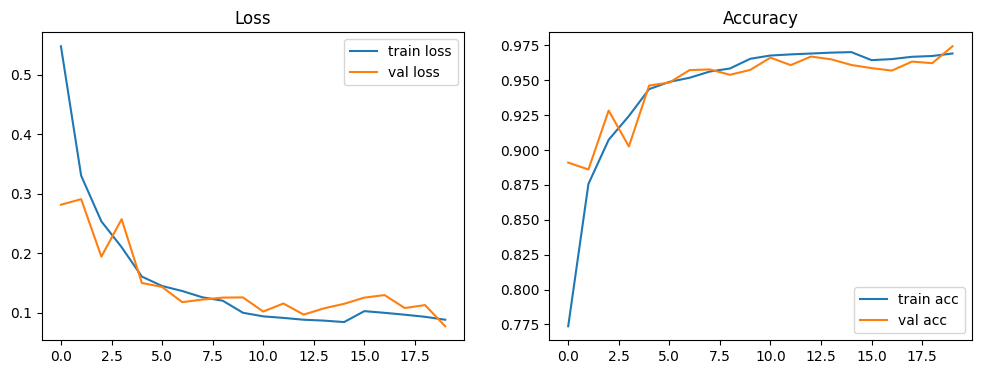

1773/1773 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8986 - loss: 0.3802
FINAL Test accuracy: 0.8986, loss: 0.3802
Test acc history (per epoch): [0.8733494281768799, 0.8777039051055908, 0.8850730657577515, 0.8835216760635376, 0.8986302018165588]


In [20]:
# Cell D: evaluate and plot combined histories
import matplotlib.pyplot as plt
import numpy as np

# combine histories if you have both history and history2
def combine_hist(h1, h2):
    if h1 is None: return h2.history
    out = {}
    for k in set(list(h1.history.keys()) + list(h2.history.keys())):
        out[k] = h1.history.get(k, []) + h2.history.get(k, [])
    return out

h_comb = combine_hist(history if 'history' in globals() else None, history2 if 'history2' in globals() else None)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(h_comb.get('loss',[]), label='train loss')
plt.plot(h_comb.get('val_loss',[]), label='val loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(h_comb.get('accuracy',[]), label='train acc')
plt.plot(h_comb.get('val_accuracy',[]), label='val acc')
plt.legend(); plt.title('Accuracy')
plt.show()

# final test eval
loss, acc = model.evaluate(test_ds, verbose=1)
print(f"FINAL Test accuracy: {acc:.4f}, loss: {loss:.4f}")

# If you used test_cb, you can also inspect its recorded history:
if 'test_cb' in globals():
    print("Test acc history (per epoch):", getattr(test_cb, 'test_acc_hist', []))


In [19]:
# Cell C: continue training
more_epochs = 20   # how many more epochs to try; adjust as needed

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=more_epochs,
    initial_epoch=history.epoch[-1] + 1 if 'history' in globals() and hasattr(history,'epoch') and len(history.epoch)>0 else 0,
    class_weight=class_weights,
    callbacks=new_callbacks + [test_cb],
    verbose=1
)


Epoch 16/20
4169/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9646 - loss: 0.1021
Epoch 16: val_accuracy improved from None to 0.95867, saving model to notebook/safe_glyphnet_best.keras
-> [Test eval] epoch 16: test_loss=0.4193, test_acc=0.8733
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 119s 28ms/step - accuracy: 0.9644 - loss: 0.1026 - val_accuracy: 0.9587 - val_loss: 0.1253 - learning_rate: 5.0000e-04
Epoch 17/20
4169/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9640 - loss: 0.1008
Epoch 17: val_accuracy did not improve from 0.95867
-> [Test eval] epoch 17: test_loss=0.3900, test_acc=0.8777
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 117s 28ms/step - accuracy: 0.9651 - loss: 0.0997 - val_accuracy: 0.9569 - val_loss: 0.1295 - learning_rate: 5.0000e-04
Epoch 18/20
4170/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9673 - loss: 0.0958
Epoch 18: val_accuracy improved from 0.95867 to 0.96335, saving model to notebook/safe_glyphnet_best.keras
-> [Test eval] epoch 18: test_loss=0.3955, test_a

In [18]:
# Cell B: per-epoch test evaluation callback
import numpy as np
class TestEvalCallback(callbacks.Callback):
    def __init__(self, test_dataset):
        super().__init__()
        self.test_ds = test_dataset
        self.test_acc_hist = []
        self.test_loss_hist = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(self.test_ds, verbose=0)
        self.test_loss_hist.append(loss)
        self.test_acc_hist.append(acc)
        print(f"-> [Test eval] epoch {epoch+1}: test_loss={loss:.4f}, test_acc={acc:.4f}")

test_cb = TestEvalCallback(test_ds)

#callback to evaluate on test set each epoch

In [17]:
# Cell A (robust): set LR safely across TF versions and create callbacks
from tensorflow.keras import callbacks, backend as K
import tensorflow as tf
import numpy as np

# Reduce LR when val_loss plateaus
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

# Save best model by validation accuracy
ckpt = callbacks.ModelCheckpoint(
    "notebook/safe_glyphnet_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# More patience for longer training
early = callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Try to set a smaller LR for this new phase in a robust way
new_lr = 5e-4
worked = False

# Attempt 1: assign() (works when learning_rate is a tf.Variable)
try:
    lr_obj = model.optimizer.learning_rate
    if hasattr(lr_obj, "assign"):
        lr_obj.assign(new_lr)
        print("Set LR via lr_obj.assign(new_lr).")
        worked = True
except Exception as e:
    print("assign() attempt failed:", e)

# Attempt 2: backend.set_value (works for some TF versions)
if not worked:
    try:
        K.set_value(model.optimizer.learning_rate, new_lr)
        print("Set LR via K.set_value(model.optimizer.learning_rate, new_lr).")
        worked = True
    except Exception as e:
        print("K.set_value attempt failed:", e)

# Attempt 3: attribute assignment (fallback)
if not worked:
    try:
        setattr(model.optimizer, "learning_rate", new_lr)
        print("Set LR via setattr(model.optimizer, 'learning_rate', new_lr).")
        worked = True
    except Exception as e:
        print("attribute assignment attempt failed:", e)

# Attempt 4: recreate optimizer & recompile model (safe fallback)
if not worked:
    try:
        print("Falling back to creating a new optimizer and recompiling model.")
        new_opt = tf.keras.optimizers.Adam(learning_rate=new_lr)
        # Note: recompile with same loss/metrics you used originally
        model.compile(optimizer=new_opt,
                      loss="sparse_categorical_crossentropy",
                      metrics=["accuracy"])
        print("Recompiled model with new optimizer (learning_rate =", new_lr, ").")
        worked = True
    except Exception as e:
        print("Recompile fallback failed:", e)
        raise RuntimeError("Couldn't set learning rate on optimizer. Inspect error above.")

# Final printout of current lr (best-effort)
try:
    lr_value = model.optimizer.learning_rate
    # try to get numeric value
    try:
        print("Current LR (tf):", float(tf.keras.backend.get_value(lr_value)))
    except Exception:
        try:
            print("Current LR (direct):", float(lr_value))
        except Exception:
            print("Current LR (unknown type):", lr_value)
except Exception:
    print("Could not read back the optimizer.learning_rate value. Proceeding anyway.")

# Collect callbacks
new_callbacks = [reduce_lr, ckpt, early]



#new callbacks (ReduceLR, checkpoint, longer patience)

Set LR via lr_obj.assign(new_lr).
Current LR (tf): 0.0005000000237487257


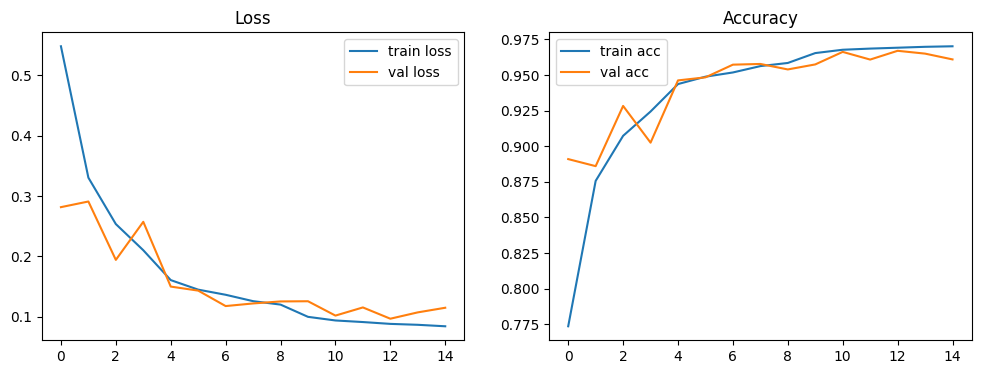

Best val_accuracy: 0.9669725894927979 at epoch 13
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8884 - loss: 0.3918

Test accuracy: 0.8884 | loss: 0.3918
Test label counts (sample): Counter({1: 19557, 0: 19284, 2: 17882})

Classification report:
              precision    recall  f1-score   support

   Corrected     0.9249    0.9409    0.9328     19284
      Normal     0.8551    0.8427    0.8489     19557
    Reversal     0.8844    0.8819    0.8831     17882

    accuracy                         0.8884     56723
   macro avg     0.8881    0.8885    0.8883     56723
weighted avg     0.8881    0.8884    0.8882     56723



2025-10-28 12:24:31.602199: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


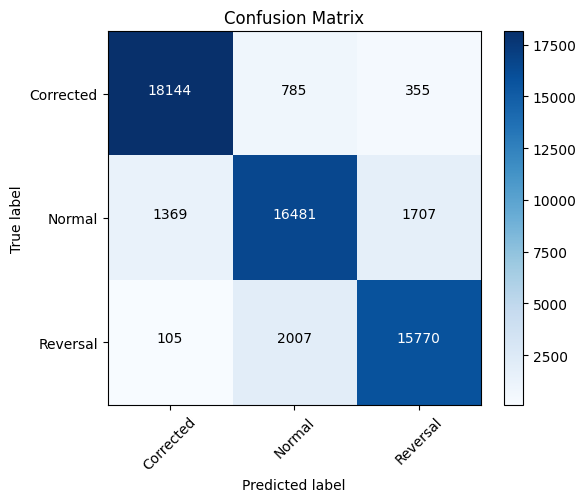

In [14]:
# Inspect training & evaluate (one cell)
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 1) Plot history if available
if 'history' in globals():
    h = history.history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.get('loss',[]), label='train loss')
    plt.plot(h.get('val_loss',[]), label='val loss')
    plt.legend(); plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(h.get('accuracy',[]), label='train acc')
    plt.plot(h.get('val_accuracy',[]), label='val acc')
    plt.legend(); plt.title('Accuracy')
    plt.show()

    best_epoch = np.argmax(h.get('val_accuracy', [0]))
    best_val = h.get('val_accuracy', [0])[best_epoch] if len(h.get('val_accuracy',[]))>0 else None
    print(f"Best val_accuracy: {best_val} at epoch {best_epoch+1}")
else:
    print("No `history` object found in this session. If you haven't trained yet, run the training cell first.")

# 2) Evaluate on test set and gather preds
if 'model' in globals() and 'test_ds' in globals():
    loss, acc = model.evaluate(test_ds, verbose=1)
    print(f"\nTest accuracy: {acc:.4f} | loss: {loss:.4f}")

    # Build y_true, y_pred arrays (may take some time)
    y_true = []
    y_pred = []
    for x,y in test_ds:
        preds = model.predict(x, verbose=0)
        y_true.extend(y.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())

    from collections import Counter
    print("Test label counts (sample):", Counter(y_true))

    # 3) Confusion matrix & classification report
    cm = confusion_matrix(y_true, y_pred)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

    # Plot confusion matrix
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(CLASS_NAMES))
    plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
    plt.yticks(tick_marks, CLASS_NAMES)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.tight_layout()
    plt.show()
else:
    print("Model or test_ds not found in current session. Make sure you ran the model creation and dataset cells.")


In [13]:
# STEP 8 — evaluate final model
loss, acc = model.evaluate(test_ds, verbose=1)
print(f"✅ Final Test Accuracy: {acc:.4f} | Loss: {loss:.4f}")

#Evaluate on test set

1773/1773 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8884 - loss: 0.3918
✅ Final Test Accuracy: 0.8884 | Loss: 0.3918


In [12]:
# STEP 7 — train safely
import traceback, sys

epochs = 15

try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
except tf.errors.ResourceExhaustedError:
    print("\n⚠️ GPU Out of Memory (OOM) Detected!")
    print("Try lowering BATCH to 16 or IMG_SIZE to 64 and rerun dataset + model cells.")
    sys.exit(1)

#Train safely (handles OOM errors)

Epoch 1/15


E0000 00:00:1761638351.171430    8205 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-10-28 07:59:12.546113: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300


4170/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6741 - loss: 0.7215
Epoch 1: val_accuracy improved from None to 0.89097, saving model to notebook/safe_glyphnet.keras
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 110s 25ms/step - accuracy: 0.7737 - loss: 0.5481 - val_accuracy: 0.8910 - val_loss: 0.2816 - learning_rate: 0.0010
Epoch 2/15
4169/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8658 - loss: 0.3552
Epoch 2: val_accuracy did not improve from 0.89097
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 103s 24ms/step - accuracy: 0.8757 - loss: 0.3304 - val_accuracy: 0.8860 - val_loss: 0.2909 - learning_rate: 0.0010
Epoch 3/15
4170/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9028 - loss: 0.2650
Epoch 3: val_accuracy improved from 0.89097 to 0.92828, saving model to notebook/safe_glyphnet.keras
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 104s 25ms/step - accuracy: 0.9073 - loss: 0.2535 - val_accuracy: 0.9283 - val_loss: 0.1942 - learning_rate: 0.0010
Epoch 4/15
4169/4171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step -

In [11]:
# STEP 6 — compile & callbacks
base_lr = 1e-3

def step_decay_lr(epoch):
    if epoch < 4: return base_lr
    if epoch < 9: return base_lr * 0.5
    return base_lr * 0.2

lr_cb = keras.callbacks.LearningRateScheduler(step_decay_lr)

callbacks = [
    lr_cb,
    keras.callbacks.ModelCheckpoint(
        "notebook/safe_glyphnet.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_lr),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [10]:
# STEP 5 — define model
from tensorflow.keras import layers

def make_safe_model(img_size=IMG_SIZE, num_classes=3):
    inp = keras.Input((img_size, img_size, 1))
    x = layers.Rescaling(1./255)(inp)
    x = data_augment(x)

    def block(x, f):
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(f, 3, padding="same", activation="relu")(x)
        x = layers.MaxPool2D()(x)
        x = layers.Dropout(0.15)(x)
        return x

    x = block(x, 32)
    x = block(x, 64)
    x = block(x, 96)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.25)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inp, out)

model = make_safe_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment (Sequential)            │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 96)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,227 (844.64 KB)

 Trainable params: 216,227 (844.64 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# STEP 4 — light augmentations
data_augment = keras.Sequential([
    keras.layers.RandomRotation(0.08),
    keras.layers.RandomZoom((-0.06, 0.06)),
    keras.layers.RandomTranslation(0.06, 0.06),
], name="augment")


In [8]:
# STEP 3 — compute class weights
from collections import Counter

labels = []
for _, y in train_ds.unbatch():
    labels.append(int(y.numpy()))

ctr = Counter(labels)
total = sum(ctr.values())
K = len(CLASS_NAMES)
class_weights = {i: total / (K * ctr.get(i, 1)) for i in range(K)}

print("train label counts:", {CLASS_NAMES[i]: ctr.get(i, 0) for i in range(K)})
print("class_weights:", {CLASS_NAMES[i]: round(class_weights[i], 4) for i in range(K)})

#Compute class weights for imbalance

train label counts: {'Corrected': 57650, 'Normal': 34588, 'Reversal': 41214}
class_weights: {'Corrected': 0.7716, 'Normal': 1.2861, 'Reversal': 1.0793}


2025-10-28 07:57:12.751561: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# STEP 2 — build datasets
import tensorflow as tf
from tensorflow import keras

TRAIN_DIR = DATA_ROOT / "Train"
TEST_DIR  = DATA_ROOT / "Test"
CLASS_NAMES = ["Corrected", "Normal", "Reversal"]
IMG_SIZE = 96
BATCH = 32
SEED = 1337

train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.12,
    subset="training",
    batch_size=BATCH
)

val_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=SEED,
    validation_split=0.12,
    subset="validation",
    batch_size=BATCH
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASS_NAMES,
    color_mode="grayscale",
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=False,
    batch_size=BATCH
)

# Only prefetch (no cache → avoids RAM spike)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(2000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 151649 files belonging to 3 classes.
Using 133452 files for training.


I0000 00:00:1761638172.740974    8205 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 151649 files belonging to 3 classes.
Using 18197 files for validation.
Found 56723 files belonging to 3 classes.


In [6]:
# STEP 1 — set correct dataset path
from pathlib import Path

DATA_ROOT = Path("/home/madhavan_1502/project_ai/dataset").resolve()
print("DATA_ROOT exists?", DATA_ROOT.exists(), DATA_ROOT)
print("Subfolders:", [p.name for p in DATA_ROOT.iterdir() if p.is_dir()])



DATA_ROOT exists? True /home/madhavan_1502/project_ai/dataset
Subfolders: ['Train', 'Test']


In [4]:
# STEP 1
import os, pathlib
print("CWD:", os.getcwd())
print("Items in CWD:", [p.name for p in pathlib.Path.cwd().iterdir()])


CWD: /home/madhavan_1502/project_ai/notebook
Items in CWD: ['best_model.h5', 'eval_model.ipynb', 'best_model.keras', 'best_model_finetuned.keras', 'train_model.ipynb', 'best_model_finetuned_balanced.keras', 'train_clean_glyphs.ipynb', 'best_glyphnet.keras']


In [3]:
import pathlib

def locate_dataset(start=pathlib.Path.cwd(), max_up=3):
    # try common relatives
    candidates = [
        start / "dataset",
        start.parent / "dataset",
        start.parent.parent / "dataset",
        start / "../dataset",
        start / "../../dataset",
    ]
    # search upward
    ups = [start] + list(start.parents)[:max_up]
    for up in ups:
        candidates += list(up.glob("**/dataset"))

    # validate
    for p in candidates:
        if not p.exists(): 
            continue
        for TT in ("Train","train"):
            for tT in ("Test","test"):
                if (p/TT).is_dir() and (p/tT).is_dir():
                    return p, (TT, tT)
    return None, (None, None)

DATA_ROOT, (TRAIN_NAME, TEST_NAME) = locate_dataset()
print("DATA_ROOT:", DATA_ROOT)
print("Train dir name found:", TRAIN_NAME, "| Test dir name found:", TEST_NAME)


DATA_ROOT: /home/madhavan_1502/project_ai/dataset
Train dir name found: Train | Test dir name found: Test


In [2]:
import pathlib, os
print("CWD:", os.getcwd())
print("Here:", pathlib.Path.cwd())
print("List here:", [p.name for p in pathlib.Path.cwd().iterdir()])



CWD: /home/madhavan_1502/project_ai/notebook
Here: /home/madhavan_1502/project_ai/notebook
List here: ['best_model.h5', 'eval_model.ipynb', 'best_model.keras', 'best_model_finetuned.keras', 'train_model.ipynb', 'best_model_finetuned_balanced.keras', 'train_clean_glyphs.ipynb', 'best_glyphnet.keras']
